## Практическое задание

Вариант 1. (простой)

- обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на датасете fashion-mnist или cifar10
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
- (опциционально)сравнить с точностью полносвязной сети для этой выборки
    </li>

Вариант 2. (сложный)
- реализовать нейронную сеть или стек из сверток (Concatenate) на сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер), больше нитей.
- оценить рост точности при увеличении глубины сети (больше слоев)
    </li>
</ol>

In [1]:
from __future__ import print_function
import tensorflow.keras as keras # расскоментируйте эту строку, чтобы начать обучение
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AvgPool2D
from tensorflow.keras.utils import plot_model 
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Установим параметры модели и скачаем датасет.

In [2]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']
# установка параметров нейросети
batch_size = 32
num_classes = 10
epochs = 1
data_augmentation = False
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Нормируем данные
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [3]:
def test_alexnet(x_train, y_train, x_test, y_test, add_num_cores=0, add_layers=0):
    
    # конфигурирование слоев нейросети
    model = Sequential()

    # слои нейросети отвественные за свертку и max-pooling
    model.add(Conv2D(32 + add_num_cores, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32 + add_num_cores, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout( 0.25))

    model.add(Conv2D(64 + add_num_cores, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64 + add_num_cores, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    for i in range(add_layers):
        model.add(Conv2D(64 + add_num_cores + (32*(i+1)), (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(Conv2D(64 + add_num_cores + (32*(i+1)), (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
    # полносвязные слои нейронной сети
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # компиляция модели
    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])



    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True, verbose=0)

    # проверка работы обученной модели
    scores = model.evaluate(x_test, y_test, verbose=0)
    result = {'Количество доп ядер' : add_num_cores, 'Доп слои свертки' : add_layers, 'Test accuracy' : scores[1]}
    return result

In [4]:
table = {'Количество доп ядер' : [], 'Доп слои свертки' : [], 'Test accuracy' : []}

In [5]:
cores=[8,16,32,64]

In [6]:
for add_num_cores in cores:        
    spam = test_alexnet(x_train, y_train, x_test, y_test, add_num_cores)
    for i in table:
        table[i].append(spam[i])

In [7]:
layers=[1,2]

In [8]:
for add_layers in layers:        
    spam = test_alexnet(x_train, y_train, x_test, y_test, add_num_cores=0, add_layers=add_layers)
    for i in table:
        table[i].append(spam[i])

In [9]:
results = pd.DataFrame(table)

In [10]:
results

,Количество доп ядер,Доп слои свертки,Test accuracy
0,8,0,0.3394
1,16,0,0.2932
2,32,0,0.3541
3,64,0,0.3662
4,0,1,0.2405
5,0,2,0.1771


#### В итоге получилось, что при добавлении числа ядер, качество улучалось, а при добавлении слоев ухудшалось.

## Вариант 2. (сложный)

- реализовать нейронную сеть или стек из сверток (Concatenate) на сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер), больше нитей.
- оценить рост точности при увеличении глубины сети (больше слоев)

#### Т.к. долго писать автотест для нескольких вариантов, буду делать вручную.

- инпут один для всех

In [53]:
all_input = Input(shape=(x_train.shape[1:]))

### Создадим 1 нить

- Первая нить

In [54]:
first=Conv2D(16, 3, activation='relu', padding = 'same')(all_input)
first=Conv2D(32, 3, activation='relu')(first)
first=MaxPooling2D(pool_size=(2, 2))(first)
first=Flatten()(first)
first_dense =  Dense(512, activation='relu')(first)


### Объединяем в 1 сетку

In [55]:
merge_all = Concatenate(  axis =-1 )([first_dense])

- Конечное выстраивание в вектор и добавление софтмакса для классификации

In [56]:
merge_final=Flatten()(merge_all)
merge_final=Dense(10, activation='softmax')(merge_final)


In [57]:
model_stek = Model(inputs=all_input, outputs=merge_final)

### Компиляция модели

In [58]:
ada_grad = tf.keras.optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model_stek.compile(optimizer=ada_grad, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Обучение модели

In [59]:
model_stek.fit(x_train,y_train, epochs = 5, validation_split=0.2)

Epoch 1/5
1250/1250 [==============================] - 6s 4ms/step - loss: 1.7204 - accuracy: 0.3848 - val_loss: 1.4543 - val_accuracy: 0.4838
Epoch 2/5
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3565 - accuracy: 0.5183 - val_loss: 1.3095 - val_accuracy: 0.5417
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2066 - accuracy: 0.5764 - val_loss: 1.2151 - val_accuracy: 0.5772
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0950 - accuracy: 0.6183 - val_loss: 1.1437 - val_accuracy: 0.6024
Epoch 5/5
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0016 - accuracy: 0.6540 - val_loss: 1.1229 - val_accuracy: 0.6112


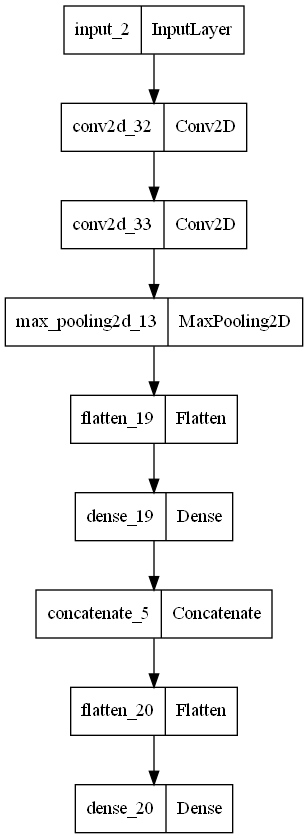

In [60]:
plot_model(model_stek,'model_stek.png')

In [61]:
print(f'Точность accuracy: {model_stek.evaluate(x_test,y_test, verbose=0)[1]}')

Точность accuracy: 0.6159999966621399


### Создадим 2 нити

- Первая нить

In [62]:
first=Conv2D(16, 3, activation='relu', padding = 'same')(all_input)
first=Conv2D(32, 3, activation='relu')(first)
first=MaxPooling2D(pool_size=(2, 2))(first)
first=Flatten()(first)
first_dense =  Dense(512, activation='relu')(first)


- Вторая нить

In [63]:
second=Conv2D(32, 2, activation='relu', padding = 'same')(all_input)
second=Conv2D(64, 2, activation='relu')(second)
second=MaxPooling2D(pool_size=(2, 2))(second)
second=Flatten()(second)
second_dense =  Dense(512, activation='relu')(second)


### Объединяем в 1 сетку

In [64]:
merge_all = Concatenate(  axis =-1 )([first_dense, second_dense])

- Конечное выстраивание в вектор и добавление софтмакса для классификации

In [65]:
merge_final=Flatten()(merge_all)
merge_final=Dense(10, activation='softmax')(merge_final)


In [66]:
model_stek = Model(inputs=all_input, outputs=merge_final)

### Компиляция модели

In [67]:
ada_grad = tf.keras.optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model_stek.compile(optimizer=ada_grad, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Обучение модели

In [68]:
model_stek.fit(x_train,y_train, epochs = 5, validation_split=0.2)

Epoch 1/5
1250/1250 [==============================] - 9s 7ms/step - loss: 1.7446 - accuracy: 0.3770 - val_loss: 1.4993 - val_accuracy: 0.4609
Epoch 2/5
1250/1250 [==============================] - 8s 6ms/step - loss: 1.3960 - accuracy: 0.5021 - val_loss: 1.3652 - val_accuracy: 0.5195
Epoch 3/5
1250/1250 [==============================] - 8s 6ms/step - loss: 1.2423 - accuracy: 0.5592 - val_loss: 1.2484 - val_accuracy: 0.5580
Epoch 4/5
1250/1250 [==============================] - 8s 6ms/step - loss: 1.1299 - accuracy: 0.6029 - val_loss: 1.1942 - val_accuracy: 0.5792
Epoch 5/5
1250/1250 [==============================] - 8s 6ms/step - loss: 1.0369 - accuracy: 0.6372 - val_loss: 1.1571 - val_accuracy: 0.5922


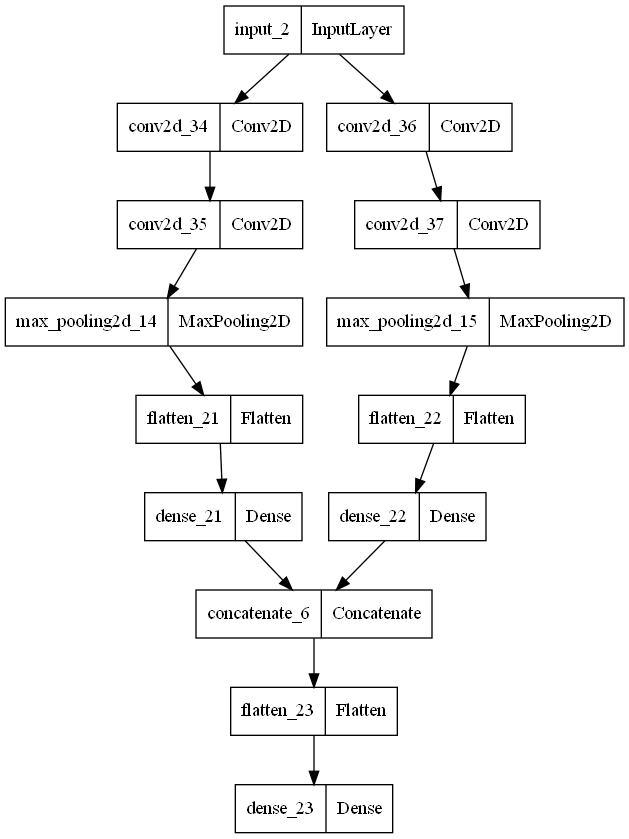

In [69]:
plot_model(model_stek,'model_stek.png')

In [70]:
print(f'Точность accuracy: {model_stek.evaluate(x_test,y_test, verbose=0)[1]}')

Точность accuracy: 0.5968000292778015


### Создадим 3 нити

- Первая нить

In [71]:
first=Conv2D(16, 3, activation='relu', padding = 'same')(all_input)
first=Conv2D(32, 3, activation='relu')(first)
first=MaxPooling2D(pool_size=(2, 2))(first)
first=Flatten()(first)
first_dense =  Dense(512, activation='relu')(first)


- Вторая нить

In [72]:
second=Conv2D(32, 2, activation='relu', padding = 'same')(all_input)
second=Conv2D(64, 2, activation='relu')(second)
second=MaxPooling2D(pool_size=(2, 2))(second)
second=Flatten()(second)
second_dense =  Dense(512, activation='relu')(second)


- Третья нить

In [73]:
third=Conv2D(32, 5, activation='relu', padding = 'same')(all_input)
third=Conv2D(64, 5, activation='relu')(third)
third=AvgPool2D(pool_size=(2, 2))(third)
third=Flatten()(third)
third_dense =  Dense(512, activation='relu')(third)

### Объединяем в 1 сетку

In [74]:
merge_all = Concatenate(  axis =-1 )([first_dense, second_dense,third_dense])

- Конечное выстраивание в вектор и добавление софтмакса для классификации

In [75]:
merge_final=Flatten()(merge_all)
merge_final=Dense(10, activation='softmax')(merge_final)


In [76]:
model_stek = Model(inputs=all_input, outputs=merge_final)

### Компиляция модели

In [77]:
ada_grad = tf.keras.optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model_stek.compile(optimizer=ada_grad, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Обучение модели

In [78]:
model_stek.fit(x_train,y_train, epochs = 5, validation_split=0.2)

Epoch 1/5
1250/1250 [==============================] - 13s 10ms/step - loss: 1.7269 - accuracy: 0.3826 - val_loss: 1.4729 - val_accuracy: 0.4780
Epoch 2/5
1250/1250 [==============================] - 12s 10ms/step - loss: 1.3794 - accuracy: 0.5107 - val_loss: 1.3055 - val_accuracy: 0.5384
Epoch 3/5
1250/1250 [==============================] - 13s 10ms/step - loss: 1.2037 - accuracy: 0.5754 - val_loss: 1.1822 - val_accuracy: 0.5895
Epoch 4/5
1250/1250 [==============================] - 12s 10ms/step - loss: 1.0777 - accuracy: 0.6241 - val_loss: 1.1057 - val_accuracy: 0.6097
Epoch 5/5
1250/1250 [==============================] - 13s 10ms/step - loss: 0.9743 - accuracy: 0.6614 - val_loss: 1.0598 - val_accuracy: 0.6385


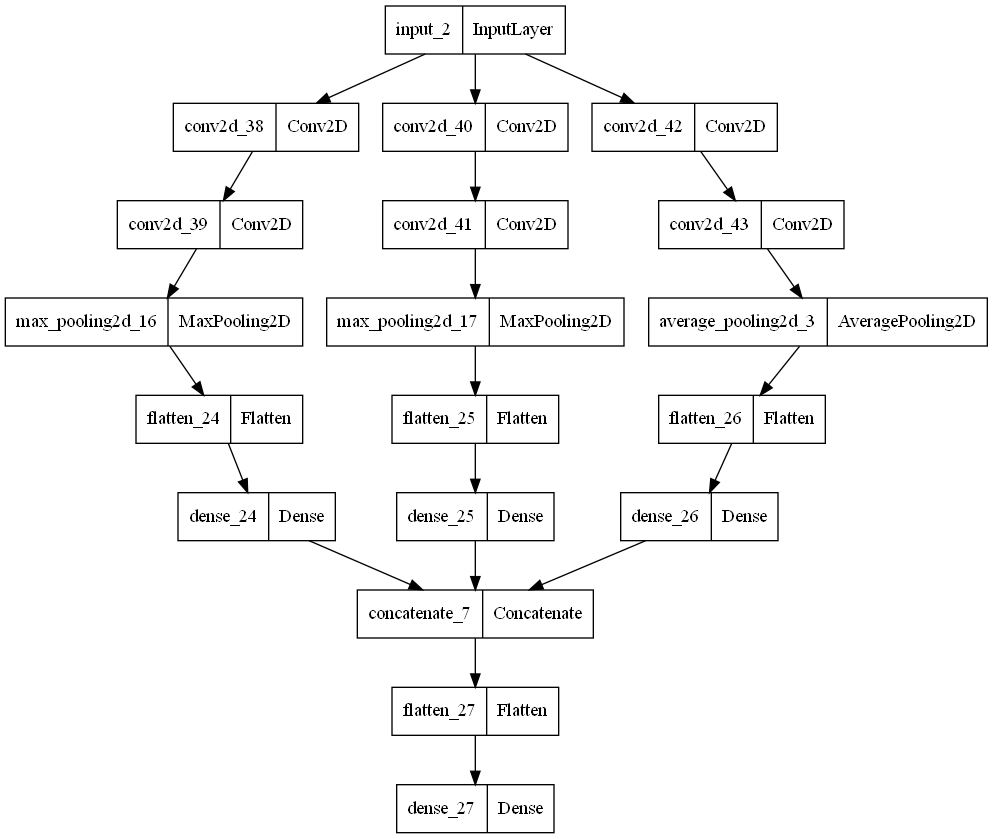

In [79]:
plot_model(model_stek,'model_stek.png')

In [80]:
print(f'Точность accuracy: {model_stek.evaluate(x_test,y_test, verbose=0)[1]}')

Точность accuracy: 0.6341999769210815


### Создадим 4 нити

- Первая нить

In [81]:
first=Conv2D(16, 3, activation='relu', padding = 'same')(all_input)
first=Conv2D(32, 3, activation='relu')(first)
first=MaxPooling2D(pool_size=(2, 2))(first)
first=Flatten()(first)
first_dense =  Dense(512, activation='relu')(first)


- Вторая нить

In [82]:
second=Conv2D(32, 2, activation='relu', padding = 'same')(all_input)
second=Conv2D(64, 2, activation='relu')(second)
second=MaxPooling2D(pool_size=(2, 2))(second)
second=Flatten()(second)
second_dense =  Dense(512, activation='relu')(second)


- Третья нить

In [83]:
third=Conv2D(32, 5, activation='relu', padding = 'same')(all_input)
third=Conv2D(64, 5, activation='relu')(third)
third=AvgPool2D(pool_size=(2, 2))(third)
third=Flatten()(third)
third_dense =  Dense(512, activation='relu')(third)

- Четвертая нить

In [84]:
fourth=Conv2D(32, 3, activation='relu', padding = 'same')(all_input)
fourth=Conv2D(32, 3, activation='relu')(fourth)
fourth=MaxPooling2D(pool_size=(2, 2))(fourth)
fourth=Dropout(0.25)(fourth)
fourth=Conv2D(64, 3, activation='relu', padding = 'same')(fourth)
fourth=Conv2D(64, 3, activation='relu')(fourth)
fourth=MaxPooling2D(pool_size=(2, 2))(fourth)
fourth=Flatten()(fourth)
fourth=Dropout(0.25)(fourth)
fourth_dense =  Dense(512, activation='relu')(fourth)

### Объединяем в 1 сетку

In [85]:
merge_all = Concatenate(  axis =-1 )([first_dense, second_dense,third_dense,fourth_dense])

- Конечное выстраивание в вектор и добавление софтмакса для классификации

In [86]:
merge_final=Flatten()(merge_all)
merge_final=Dense(10, activation='softmax')(merge_final)


In [87]:
model_stek = Model(inputs=all_input, outputs=merge_final)

### Компиляция модели

In [88]:
ada_grad = tf.keras.optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model_stek.compile(optimizer=ada_grad, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Обучение модели

In [89]:
model_stek.fit(x_train,y_train, epochs = 5, validation_split=0.2)

Epoch 1/5
1250/1250 [==============================] - 17s 13ms/step - loss: 1.7405 - accuracy: 0.3766 - val_loss: 1.4675 - val_accuracy: 0.4801
Epoch 2/5
1250/1250 [==============================] - 16s 13ms/step - loss: 1.3717 - accuracy: 0.5144 - val_loss: 1.3303 - val_accuracy: 0.5390
Epoch 3/5
1250/1250 [==============================] - 16s 13ms/step - loss: 1.1906 - accuracy: 0.5790 - val_loss: 1.2249 - val_accuracy: 0.5644
Epoch 4/5
1250/1250 [==============================] - 16s 13ms/step - loss: 1.0615 - accuracy: 0.6278 - val_loss: 1.1031 - val_accuracy: 0.6230
Epoch 5/5
1250/1250 [==============================] - 16s 13ms/step - loss: 0.9592 - accuracy: 0.6695 - val_loss: 1.0349 - val_accuracy: 0.6433


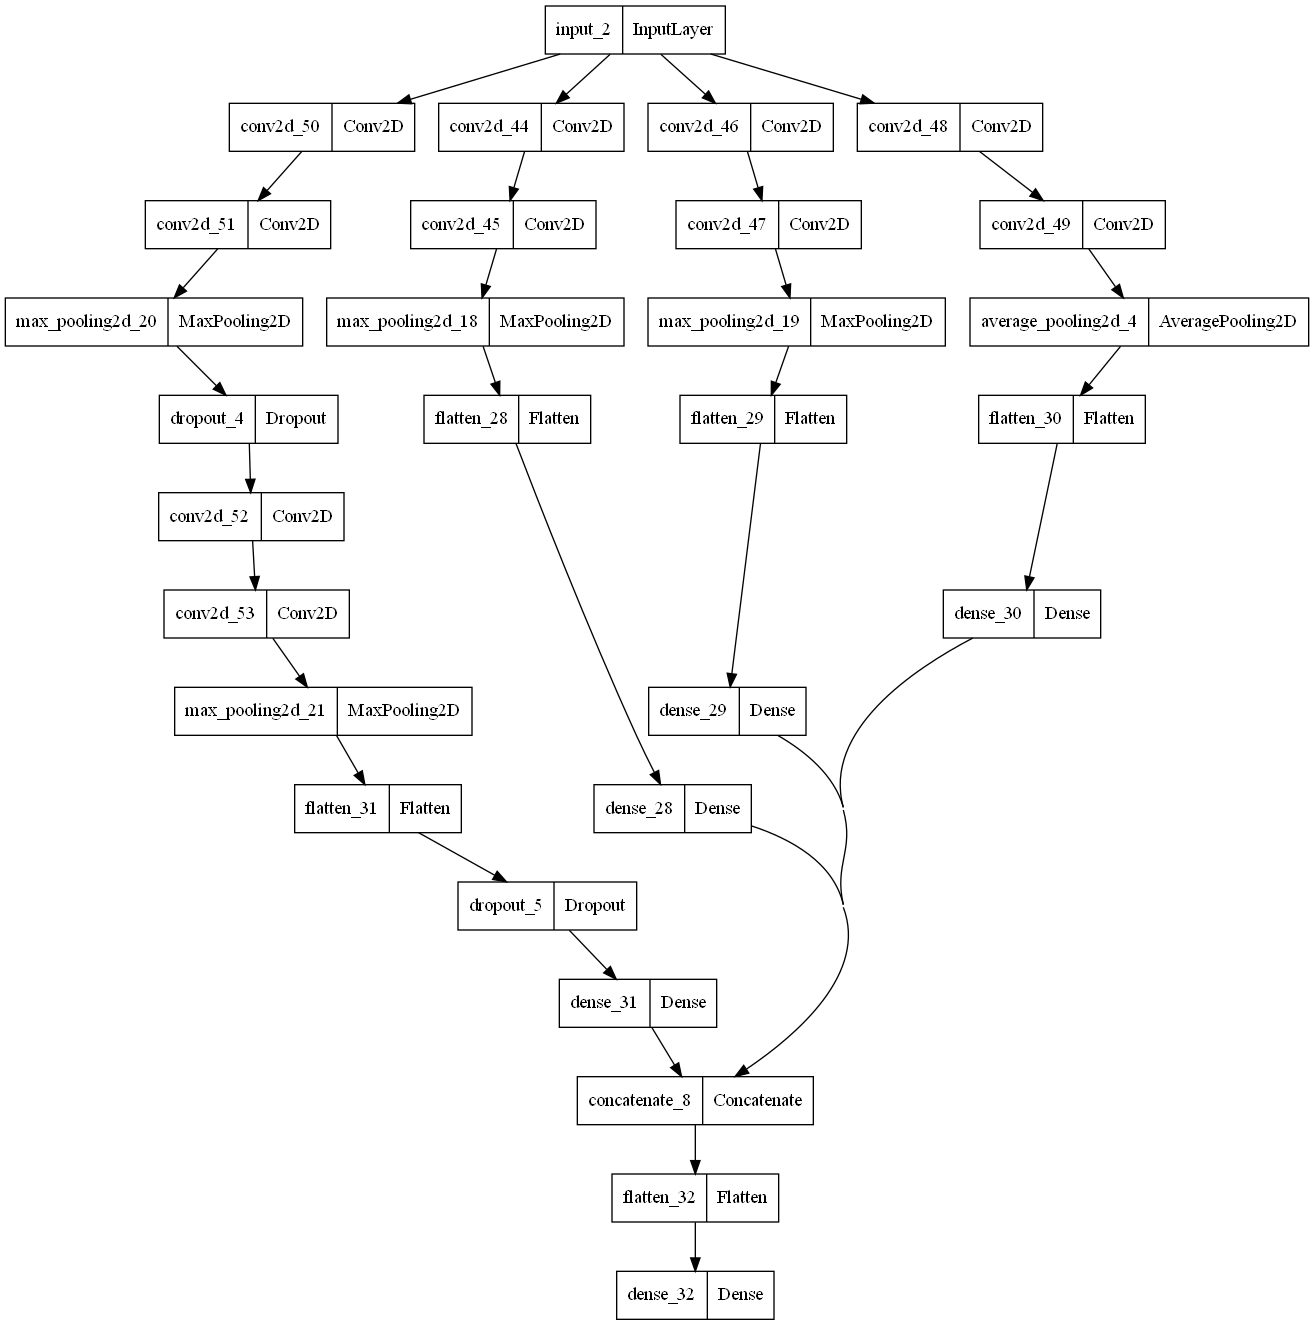

In [90]:
plot_model(model_stek,'model_stek.png')

In [91]:
print(f'Точность accuracy: {model_stek.evaluate(x_test,y_test, verbose=0)[1]}')

Точность accuracy: 0.6406999826431274


#### Как мы видим, большее количество нитей дало лучшее качество, но и обучалось намного дольше относительно 1 нити.

### Попробуем добавить сверточный слой в каждую нить

In [92]:
first=Conv2D(16, 3, activation='relu', padding = 'same')(all_input)
first=Conv2D(32, 3, activation='relu')(first)
first=MaxPooling2D(pool_size=(2, 2))(first)
first=Conv2D(64, 5, activation='relu', padding = 'same')(first)
first=Flatten()(first)
first_dense =  Dense(512, activation='relu')(first)


- Вторая нить

In [93]:
second=Conv2D(32, 2, activation='relu', padding = 'same')(all_input)
second=Conv2D(64, 2, activation='relu')(second)
second=MaxPooling2D(pool_size=(2, 2))(second)
second=Conv2D(64, 5, activation='relu', padding = 'same')(second)
second=Flatten()(second)
second_dense =  Dense(512, activation='relu')(second)


- Третья нить

In [94]:
third=Conv2D(32, 5, activation='relu', padding = 'same')(all_input)
third=Conv2D(64, 5, activation='relu')(third)
third=AvgPool2D(pool_size=(2, 2))(third)
third=Conv2D(64, 5, activation='relu', padding = 'same')(third)
third=Flatten()(third)
third_dense =  Dense(512, activation='relu')(third)

- Четвертая нить

In [95]:
fourth=Conv2D(32, 3, activation='relu', padding = 'same')(all_input)
fourth=Conv2D(32, 3, activation='relu')(fourth)
fourth=MaxPooling2D(pool_size=(2, 2))(fourth)
fourth=Dropout(0.25)(fourth)
fourth=Conv2D(64, 3, activation='relu', padding = 'same')(fourth)
fourth=Conv2D(64, 3, activation='relu')(fourth)
fourth=MaxPooling2D(pool_size=(2, 2))(fourth)
fourth=Conv2D(64, 5, activation='relu', padding = 'same')(fourth)
fourth=Conv2D(64, 5, activation='relu')(fourth)
fourth=Flatten()(fourth)
fourth=Dropout(0.25)(fourth)
fourth_dense =  Dense(512, activation='relu')(fourth)

### Объединяем в 1 сетку

In [96]:
merge_all = Concatenate(  axis =-1 )([first_dense, second_dense,third_dense,fourth_dense])

- Конечное выстраивание в вектор и добавление софтмакса для классификации

In [97]:
merge_final=Flatten()(merge_all)
merge_final=Dense(10, activation='softmax')(merge_final)


In [98]:
model_stek = Model(inputs=all_input, outputs=merge_final)

### Компиляция модели

In [99]:
ada_grad = tf.keras.optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model_stek.compile(optimizer=ada_grad, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Обучение модели

In [100]:
model_stek.fit(x_train,y_train, epochs = 5, validation_split=0.2)

Epoch 1/5
1250/1250 [==============================] - 22s 17ms/step - loss: 1.7292 - accuracy: 0.3801 - val_loss: 1.4632 - val_accuracy: 0.4851
Epoch 2/5
1250/1250 [==============================] - 20s 16ms/step - loss: 1.3375 - accuracy: 0.5257 - val_loss: 1.2555 - val_accuracy: 0.5580
Epoch 3/5
1250/1250 [==============================] - 20s 16ms/step - loss: 1.1457 - accuracy: 0.5959 - val_loss: 1.1084 - val_accuracy: 0.6206
Epoch 4/5
1250/1250 [==============================] - 20s 16ms/step - loss: 1.0043 - accuracy: 0.6473 - val_loss: 1.0223 - val_accuracy: 0.6447
Epoch 5/5
1250/1250 [==============================] - 20s 16ms/step - loss: 0.8866 - accuracy: 0.6911 - val_loss: 0.9505 - val_accuracy: 0.6757


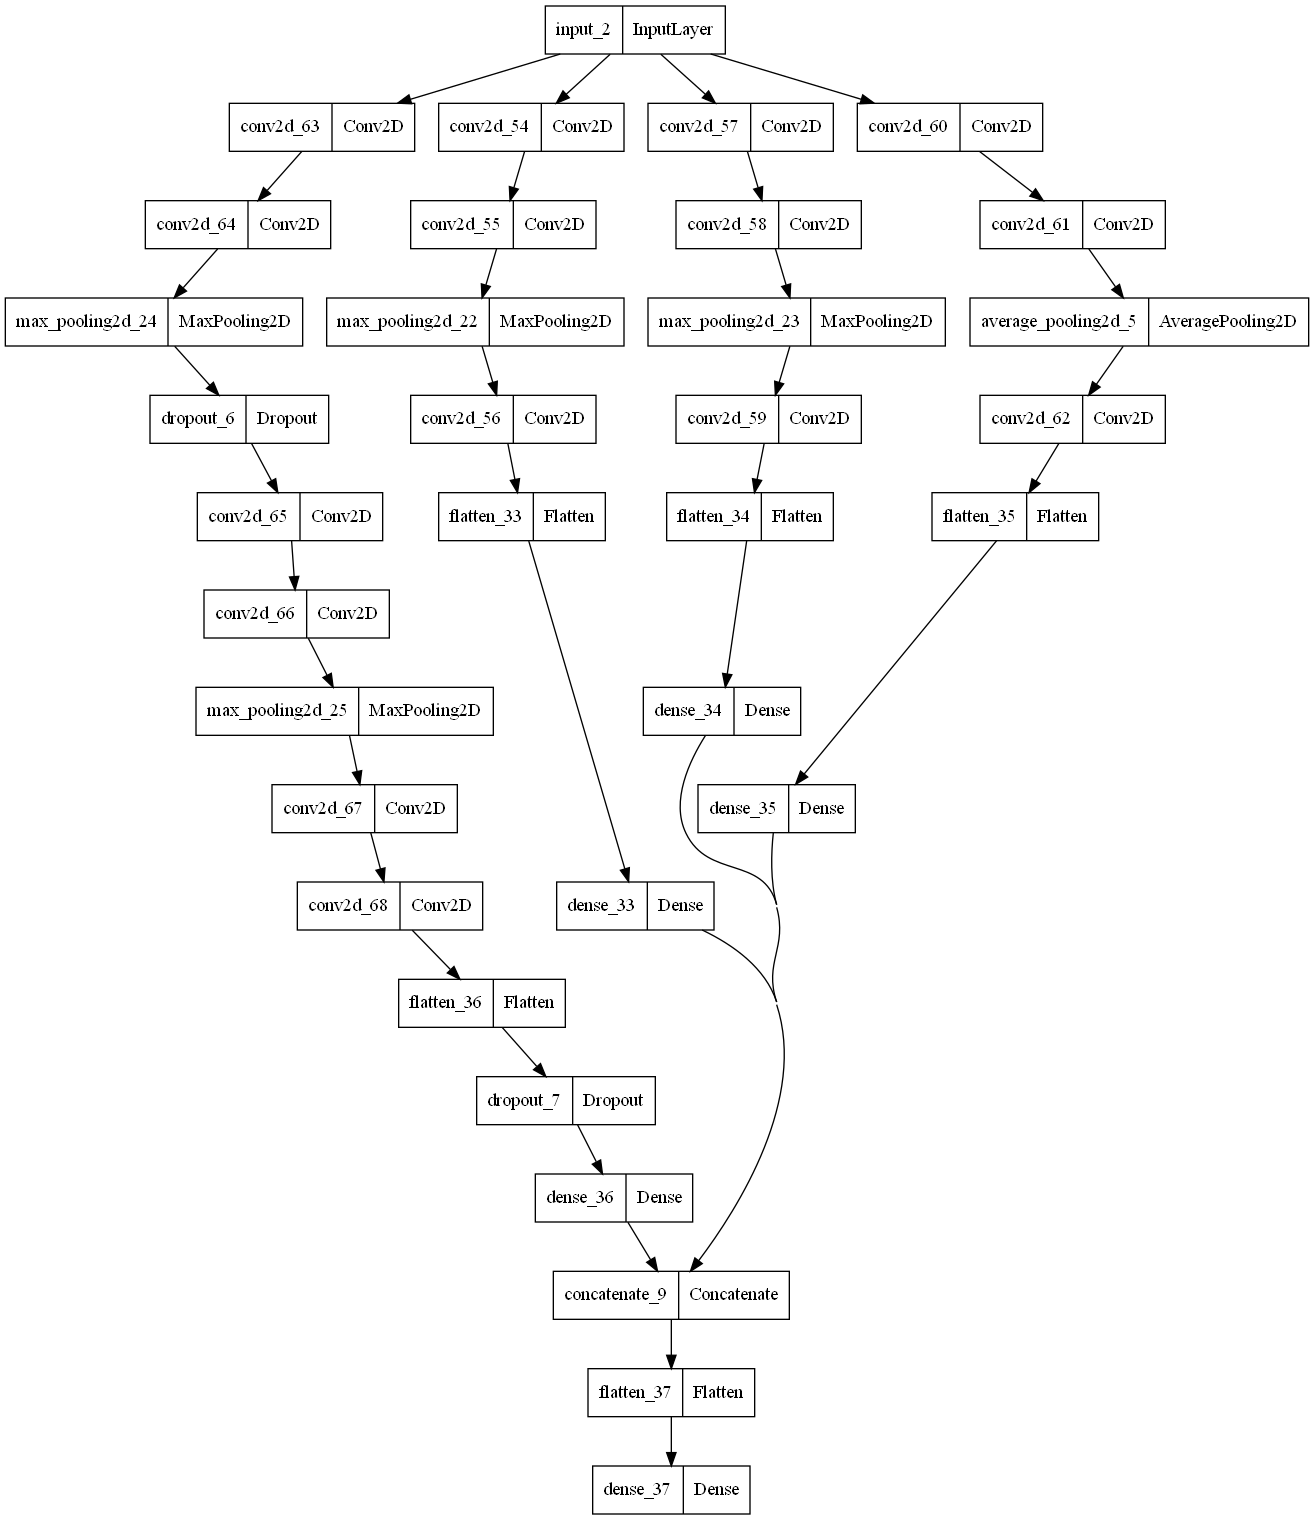

In [101]:
plot_model(model_stek,'model_stek.png')

In [102]:
print(f'Точность accuracy: {model_stek.evaluate(x_test,y_test, verbose=0)[1]}')

Точность accuracy: 0.6676999926567078


#### С добавлением слоя качество подросло.

### Попробуем увеличить в 2 раза количество ядер на каждом слое.

In [137]:
first=Conv2D(32, 3, activation='relu', padding = 'same')(all_input)
first=Conv2D(64, 3, activation='relu')(first)
first=MaxPooling2D(pool_size=(2, 2))(first)
first=Conv2D(128, 5, activation='relu', padding = 'same')(first)
first=Flatten()(first)
first_dense =  Dense(512, activation='relu')(first)


- Вторая нить

In [138]:
second=Conv2D(64, 2, activation='relu', padding = 'same')(all_input)
second=Conv2D(128, 2, activation='relu')(second)
second=MaxPooling2D(pool_size=(2, 2))(second)
second=Conv2D(128, 5, activation='relu', padding = 'same')(second)
second=Flatten()(second)
second_dense =  Dense(512, activation='relu')(second)


- Третья нить

In [139]:
third=Conv2D(64, 5, activation='relu', padding = 'same')(all_input)
third=Conv2D(128, 5, activation='relu')(third)
third=AvgPool2D(pool_size=(2, 2))(third)
third=Conv2D(128, 5, activation='relu', padding = 'same')(third)
third=Flatten()(third)
third_dense =  Dense(512, activation='relu')(third)

- Четвертая нить

In [140]:
fourth=Conv2D(64, 3, activation='relu', padding = 'same')(all_input)
fourth=Conv2D(64, 3, activation='relu')(fourth)
fourth=MaxPooling2D(pool_size=(2, 2))(fourth)
fourth=Dropout(0.25)(fourth)
fourth=Conv2D(128, 3, activation='relu', padding = 'same')(fourth)
fourth=Conv2D(128, 3, activation='relu')(fourth)
fourth=MaxPooling2D(pool_size=(2, 2))(fourth)
fourth=Conv2D(128, 5, activation='relu', padding = 'same')(fourth)
fourth=Conv2D(128, 5, activation='relu')(fourth)
fourth=Flatten()(fourth)
fourth=Dropout(0.25)(fourth)
fourth_dense =  Dense(512, activation='relu')(fourth)

### Объединяем в 1 сетку

In [141]:
merge_all = Concatenate(  axis =-1 )([first_dense, second_dense,third_dense,fourth_dense])

- Конечное выстраивание в вектор и добавление софтмакса для классификации

In [142]:
merge_final=Flatten()(merge_all)
merge_final=Dense(10, activation='softmax')(merge_final)


In [143]:
model_stek = Model(inputs=all_input, outputs=merge_final)

### Компиляция модели

In [144]:
ada_grad = tf.keras.optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model_stek.compile(optimizer=ada_grad, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Обучение модели

In [145]:
model_stek.fit(x_train,y_train, epochs = 5, validation_split=0.2)

Epoch 1/5
1250/1250 [==============================] - 40s 30ms/step - loss: 1.7341 - accuracy: 0.3750 - val_loss: 1.4492 - val_accuracy: 0.4844
Epoch 2/5
1250/1250 [==============================] - 37s 30ms/step - loss: 1.3197 - accuracy: 0.5311 - val_loss: 1.2191 - val_accuracy: 0.5762
Epoch 3/5
1250/1250 [==============================] - 37s 30ms/step - loss: 1.1045 - accuracy: 0.6094 - val_loss: 1.0557 - val_accuracy: 0.6324
Epoch 4/5
1250/1250 [==============================] - 37s 30ms/step - loss: 0.9440 - accuracy: 0.6732 - val_loss: 0.9715 - val_accuracy: 0.6639
Epoch 5/5
1250/1250 [==============================] - 37s 30ms/step - loss: 0.8155 - accuracy: 0.7164 - val_loss: 0.9327 - val_accuracy: 0.6814


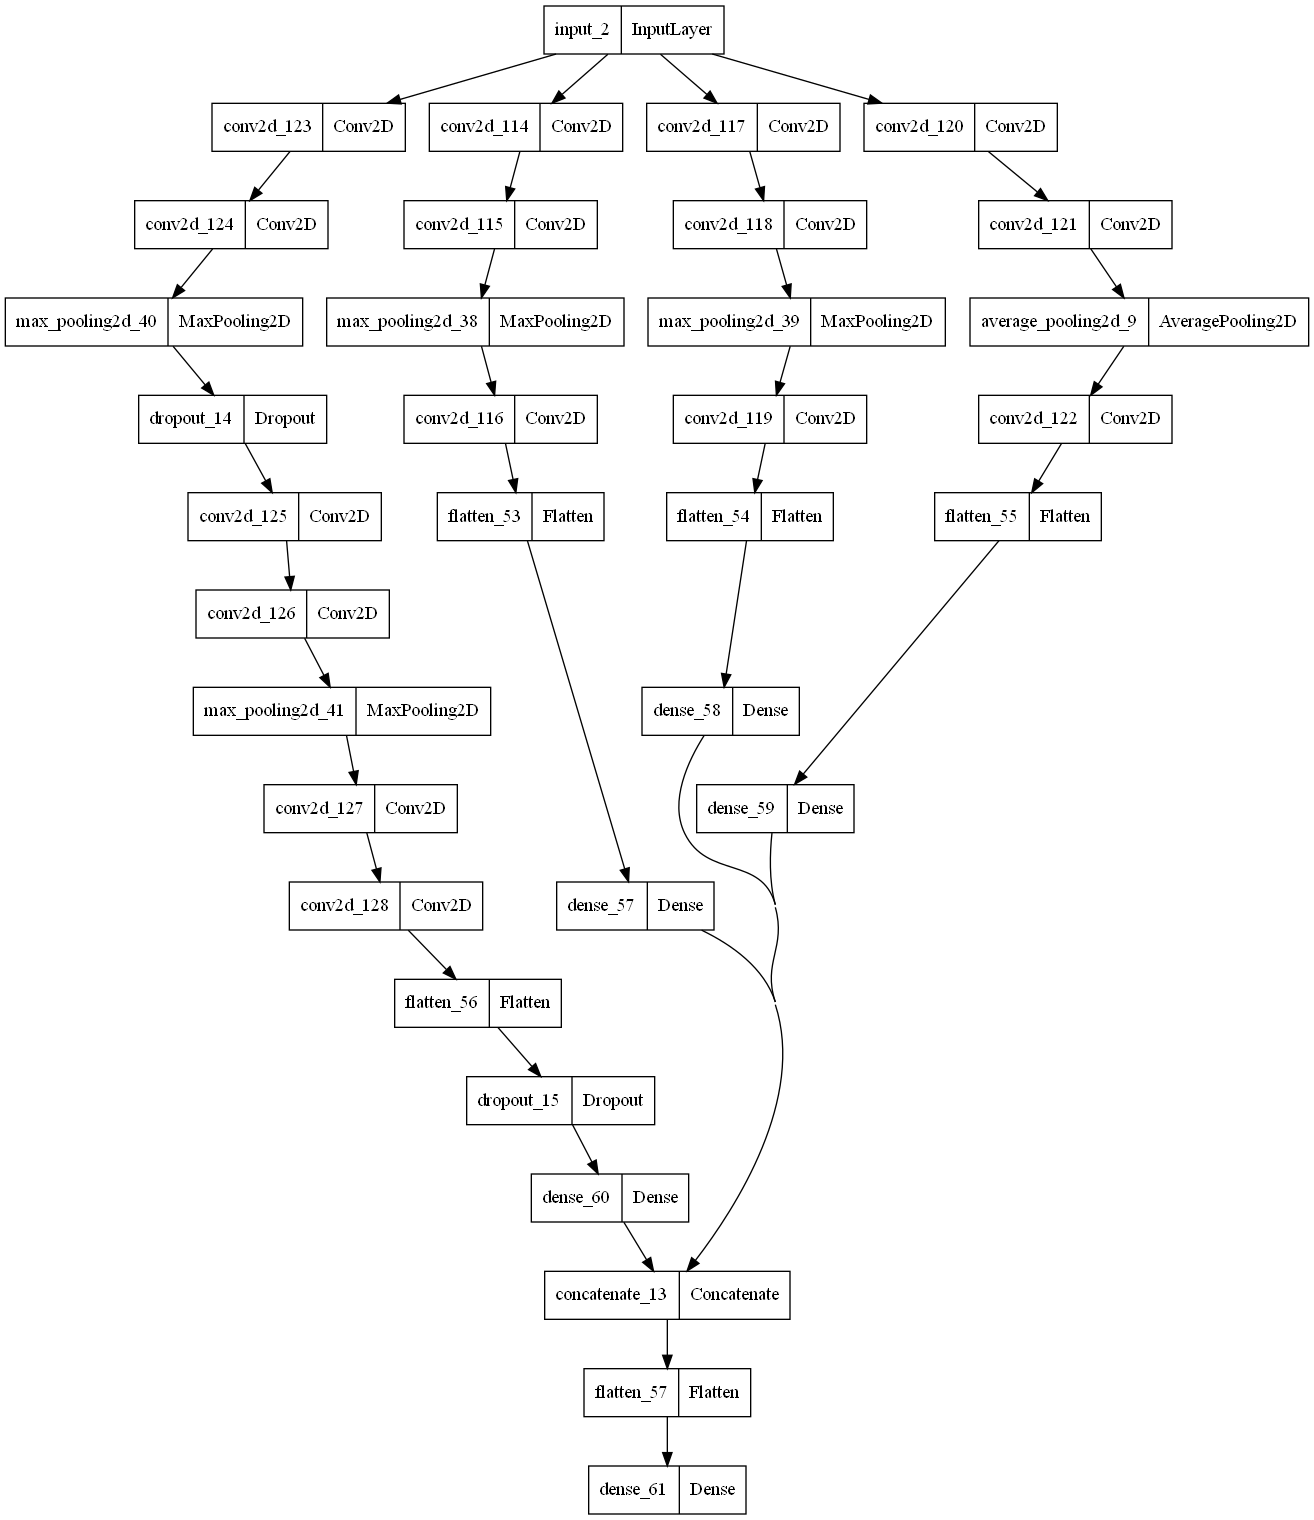

In [146]:
plot_model(model_stek,'model_stek.png')

In [147]:
print(f'Точность accuracy: {model_stek.evaluate(x_test,y_test, verbose=0)[1]}')

Точность accuracy: 0.67330002784729


#### С добавлением ядер качество улучшилось.

### Попробуем увеличить ширину полносвязного слоя каждой нити в 2 раза.

In [103]:
first=Conv2D(16, 3, activation='relu', padding = 'same')(all_input)
first=Conv2D(32, 3, activation='relu')(first)
first=MaxPooling2D(pool_size=(2, 2))(first)
first=Conv2D(64, 5, activation='relu', padding = 'same')(first)
first=Flatten()(first)
first_dense =  Dense(1024, activation='relu')(first)


- Вторая нить

In [104]:
second=Conv2D(32, 2, activation='relu', padding = 'same')(all_input)
second=Conv2D(64, 2, activation='relu')(second)
second=MaxPooling2D(pool_size=(2, 2))(second)
second=Conv2D(64, 5, activation='relu', padding = 'same')(second)
second=Flatten()(second)
second_dense =  Dense(1024, activation='relu')(second)


- Третья нить

In [105]:
third=Conv2D(32, 5, activation='relu', padding = 'same')(all_input)
third=Conv2D(64, 5, activation='relu')(third)
third=AvgPool2D(pool_size=(2, 2))(third)
third=Conv2D(64, 5, activation='relu', padding = 'same')(third)
third=Flatten()(third)
third_dense =  Dense(1024, activation='relu')(third)

- Четвертая нить

In [106]:
fourth=Conv2D(32, 3, activation='relu', padding = 'same')(all_input)
fourth=Conv2D(32, 3, activation='relu')(fourth)
fourth=MaxPooling2D(pool_size=(2, 2))(fourth)
fourth=Dropout(0.25)(fourth)
fourth=Conv2D(64, 3, activation='relu', padding = 'same')(fourth)
fourth=Conv2D(64, 3, activation='relu')(fourth)
fourth=MaxPooling2D(pool_size=(2, 2))(fourth)
fourth=Conv2D(64, 5, activation='relu', padding = 'same')(fourth)
fourth=Conv2D(64, 5, activation='relu')(fourth)
fourth=Flatten()(fourth)
fourth=Dropout(0.25)(fourth)
fourth_dense =  Dense(1024, activation='relu')(fourth)

### Объединяем в 1 сетку

In [107]:
merge_all = Concatenate(  axis =-1 )([first_dense, second_dense,third_dense,fourth_dense])

- Конечное выстраивание в вектор и добавление софтмакса для классификации

In [108]:
merge_final=Flatten()(merge_all)
merge_final=Dense(10, activation='softmax')(merge_final)


In [109]:
model_stek = Model(inputs=all_input, outputs=merge_final)

### Компиляция модели

In [110]:
ada_grad = tf.keras.optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model_stek.compile(optimizer=ada_grad, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Обучение модели

In [111]:
model_stek.fit(x_train,y_train, epochs = 5, validation_split=0.2)

Epoch 1/5
1250/1250 [==============================] - 25s 19ms/step - loss: 1.7111 - accuracy: 0.3848 - val_loss: 1.4683 - val_accuracy: 0.4793
Epoch 2/5
1250/1250 [==============================] - 23s 19ms/step - loss: 1.3321 - accuracy: 0.5273 - val_loss: 1.2484 - val_accuracy: 0.5535
Epoch 3/5
1250/1250 [==============================] - 23s 19ms/step - loss: 1.1597 - accuracy: 0.5903 - val_loss: 1.1526 - val_accuracy: 0.5918
Epoch 4/5
1250/1250 [==============================] - 23s 19ms/step - loss: 1.0265 - accuracy: 0.6402 - val_loss: 1.0658 - val_accuracy: 0.6265
Epoch 5/5
1250/1250 [==============================] - 23s 19ms/step - loss: 0.9015 - accuracy: 0.6864 - val_loss: 0.9955 - val_accuracy: 0.6583


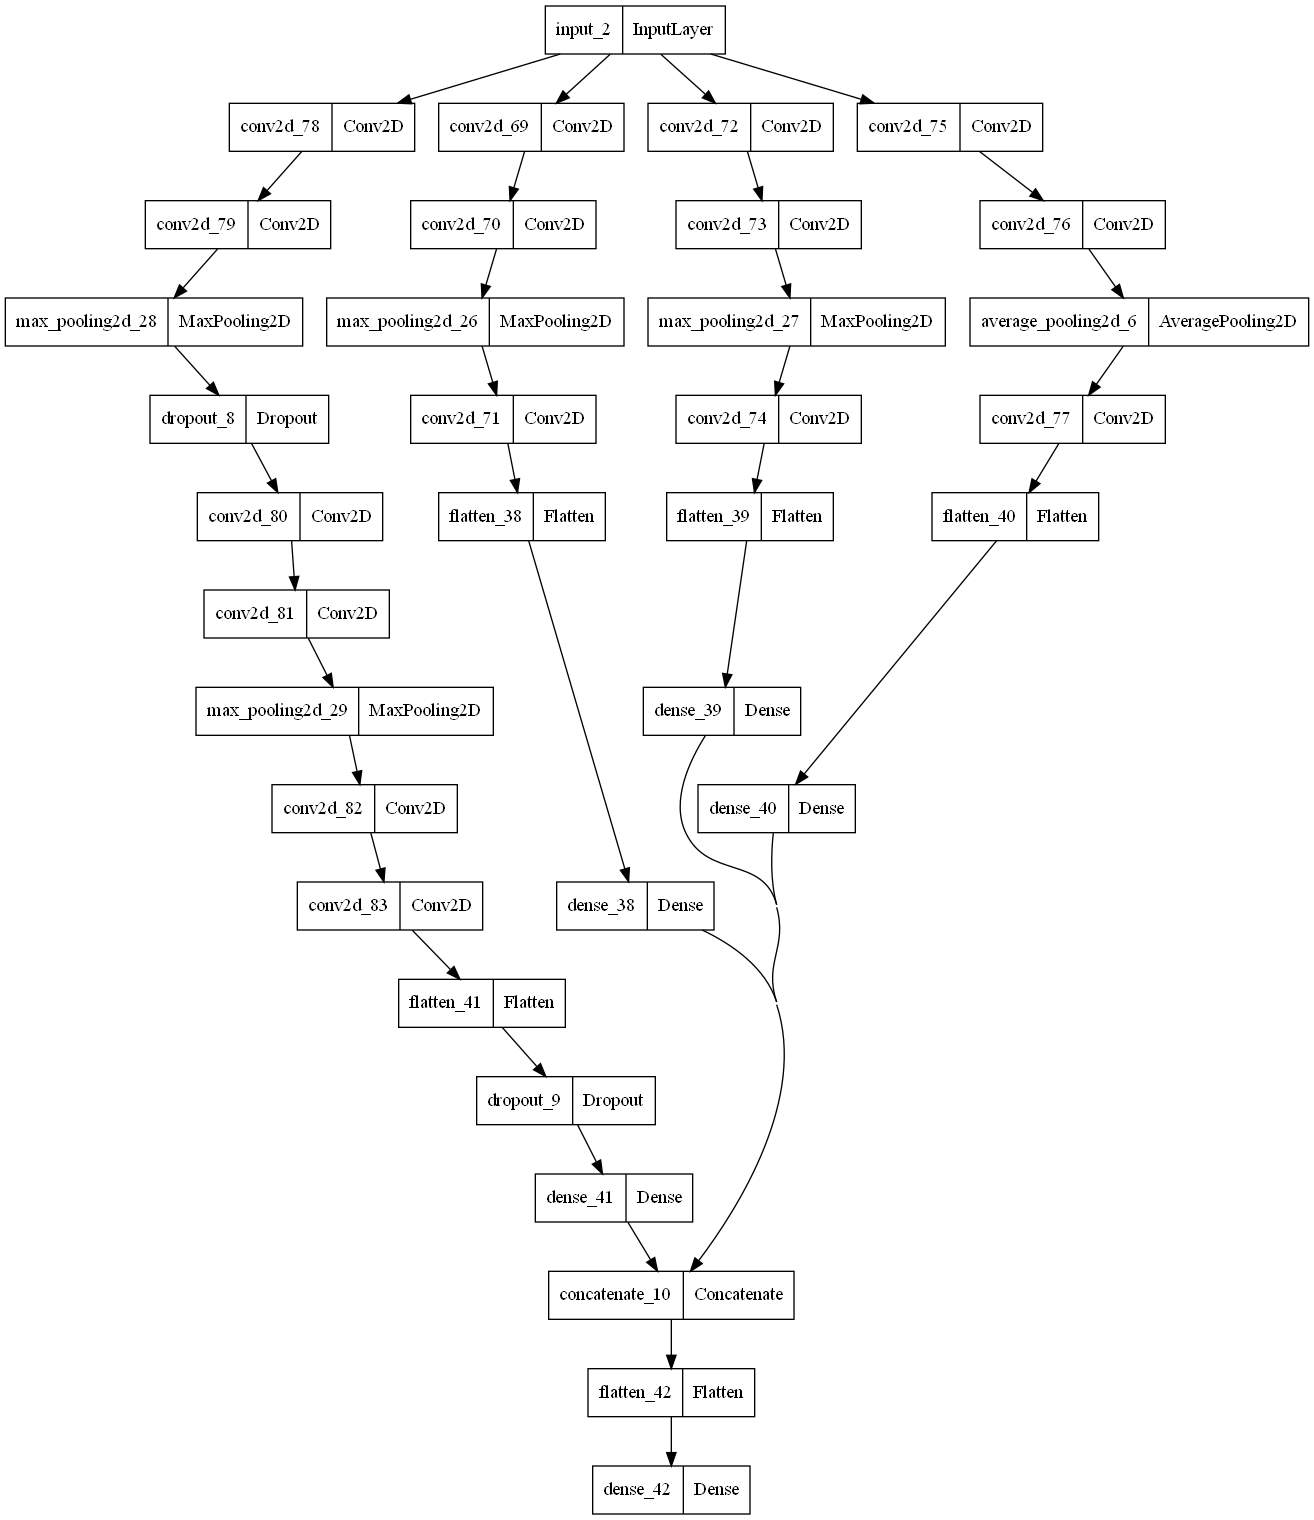

In [112]:
plot_model(model_stek,'model_stek.png')

In [113]:
print(f'Точность accuracy: {model_stek.evaluate(x_test,y_test, verbose=0)[1]}')

Точность accuracy: 0.6565999984741211


#### Улучшения не наблюдается

### Попробуем уменьшить ширину полносвязного слоя каждой нити в 2 раза.

In [126]:
first=Conv2D(16, 3, activation='relu', padding = 'same')(all_input)
first=Conv2D(32, 3, activation='relu')(first)
first=MaxPooling2D(pool_size=(2, 2))(first)
first=Conv2D(64, 5, activation='relu', padding = 'same')(first)
first=Flatten()(first)
first_dense =  Dense(256, activation='relu')(first)


- Вторая нить

In [127]:
second=Conv2D(32, 2, activation='relu', padding = 'same')(all_input)
second=Conv2D(64, 2, activation='relu')(second)
second=MaxPooling2D(pool_size=(2, 2))(second)
second=Conv2D(64, 5, activation='relu', padding = 'same')(second)
second=Flatten()(second)
second_dense =  Dense(256, activation='relu')(second)


- Третья нить

In [128]:
third=Conv2D(32, 5, activation='relu', padding = 'same')(all_input)
third=Conv2D(64, 5, activation='relu')(third)
third=AvgPool2D(pool_size=(2, 2))(third)
third=Conv2D(64, 5, activation='relu', padding = 'same')(third)
third=Flatten()(third)
third_dense =  Dense(256, activation='relu')(third)

- Четвертая нить

In [129]:
fourth=Conv2D(32, 3, activation='relu', padding = 'same')(all_input)
fourth=Conv2D(32, 3, activation='relu')(fourth)
fourth=MaxPooling2D(pool_size=(2, 2))(fourth)
fourth=Dropout(0.25)(fourth)
fourth=Conv2D(64, 3, activation='relu', padding = 'same')(fourth)
fourth=Conv2D(64, 3, activation='relu')(fourth)
fourth=MaxPooling2D(pool_size=(2, 2))(fourth)
fourth=Conv2D(64, 5, activation='relu', padding = 'same')(fourth)
fourth=Conv2D(64, 5, activation='relu')(fourth)
fourth=Flatten()(fourth)
fourth=Dropout(0.25)(fourth)
fourth_dense =  Dense(256, activation='relu')(fourth)

### Объединяем в 1 сетку

In [130]:
merge_all = Concatenate(  axis =-1 )([first_dense, second_dense,third_dense,fourth_dense])

- Конечное выстраивание в вектор и добавление софтмакса для классификации

In [131]:
merge_final=Flatten()(merge_all)
merge_final=Dense(10, activation='softmax')(merge_final)


In [132]:
model_stek = Model(inputs=all_input, outputs=merge_final)

### Компиляция модели

In [133]:
ada_grad = tf.keras.optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model_stek.compile(optimizer=ada_grad, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Обучение модели

In [134]:
model_stek.fit(x_train,y_train, epochs = 5, validation_split=0.2)

Epoch 1/5
1250/1250 [==============================] - 20s 16ms/step - loss: 1.7665 - accuracy: 0.3647 - val_loss: 1.4749 - val_accuracy: 0.4819
Epoch 2/5
1250/1250 [==============================] - 19s 15ms/step - loss: 1.3480 - accuracy: 0.5208 - val_loss: 1.2476 - val_accuracy: 0.5565
Epoch 3/5
1250/1250 [==============================] - 19s 15ms/step - loss: 1.1610 - accuracy: 0.5926 - val_loss: 1.1223 - val_accuracy: 0.6123
Epoch 4/5
1250/1250 [==============================] - 19s 15ms/step - loss: 1.0406 - accuracy: 0.6386 - val_loss: 1.0733 - val_accuracy: 0.6274
Epoch 5/5
1250/1250 [==============================] - 19s 15ms/step - loss: 0.9385 - accuracy: 0.6751 - val_loss: 0.9753 - val_accuracy: 0.6613


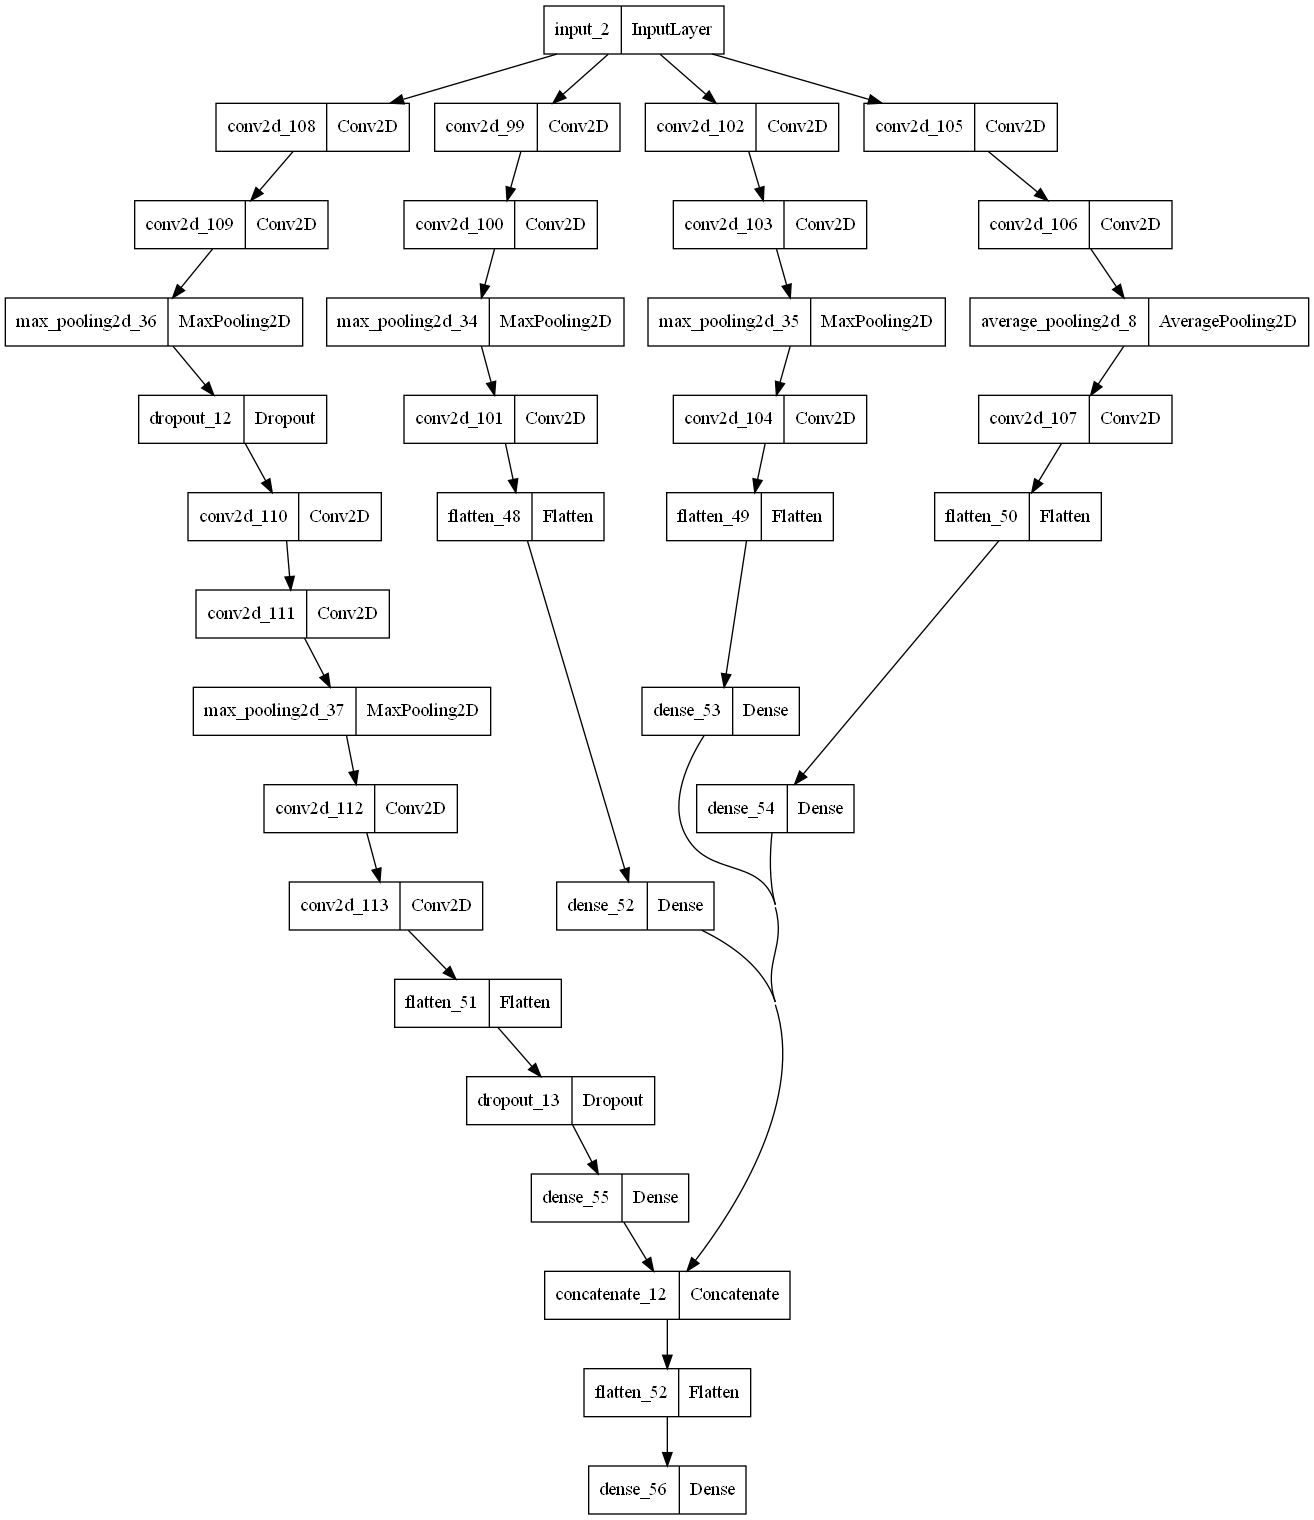

In [135]:
plot_model(model_stek,'model_stek.png')

In [136]:
print(f'Точность accuracy: {model_stek.evaluate(x_test,y_test, verbose=0)[1]}')

Точность accuracy: 0.6614999771118164


#### Стало чуть хуже

### Попробуем вместо увеличения ширины слоя, увеличить глубину, добавим по 1 полносвязному слою в каждую нить.

In [114]:
first=Conv2D(16, 3, activation='relu', padding = 'same')(all_input)
first=Conv2D(32, 3, activation='relu')(first)
first=MaxPooling2D(pool_size=(2, 2))(first)
first=Conv2D(64, 5, activation='relu', padding = 'same')(first)
first=Flatten()(first)
first_dense =  Dense(512, activation='relu')(first)
first_dense =  Dense(256, activation='relu')(first)

- Вторая нить

In [115]:
second=Conv2D(32, 2, activation='relu', padding = 'same')(all_input)
second=Conv2D(64, 2, activation='relu')(second)
second=MaxPooling2D(pool_size=(2, 2))(second)
second=Conv2D(64, 5, activation='relu', padding = 'same')(second)
second=Flatten()(second)
second_dense =  Dense(512, activation='relu')(second)
second_dense =  Dense(256, activation='relu')(second)

- Третья нить

In [116]:
third=Conv2D(32, 5, activation='relu', padding = 'same')(all_input)
third=Conv2D(64, 5, activation='relu')(third)
third=AvgPool2D(pool_size=(2, 2))(third)
third=Conv2D(64, 5, activation='relu', padding = 'same')(third)
third=Flatten()(third)
third_dense =  Dense(512, activation='relu')(third)
third_dense =  Dense(256, activation='relu')(third)

- Четвертая нить

In [117]:
fourth=Conv2D(32, 3, activation='relu', padding = 'same')(all_input)
fourth=Conv2D(32, 3, activation='relu')(fourth)
fourth=MaxPooling2D(pool_size=(2, 2))(fourth)
fourth=Dropout(0.25)(fourth)
fourth=Conv2D(64, 3, activation='relu', padding = 'same')(fourth)
fourth=Conv2D(64, 3, activation='relu')(fourth)
fourth=MaxPooling2D(pool_size=(2, 2))(fourth)
fourth=Conv2D(64, 5, activation='relu', padding = 'same')(fourth)
fourth=Conv2D(64, 5, activation='relu')(fourth)
fourth=Flatten()(fourth)
fourth=Dropout(0.25)(fourth)
fourth_dense =  Dense(512, activation='relu')(fourth)
fourth_dense =  Dense(256, activation='relu')(fourth)

### Объединяем в 1 сетку

In [118]:
merge_all = Concatenate(  axis =-1 )([first_dense, second_dense,third_dense,fourth_dense])

- Конечное выстраивание в вектор и добавление софтмакса для классификации

In [119]:
merge_final=Flatten()(merge_all)
merge_final=Dense(10, activation='softmax')(merge_final)


In [120]:
model_stek = Model(inputs=all_input, outputs=merge_final)

### Компиляция модели

In [121]:
ada_grad = tf.keras.optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model_stek.compile(optimizer=ada_grad, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Обучение модели

In [122]:
model_stek.fit(x_train,y_train, epochs = 5, validation_split=0.2)

Epoch 1/5
1250/1250 [==============================] - 20s 15ms/step - loss: 1.7485 - accuracy: 0.3693 - val_loss: 1.4984 - val_accuracy: 0.4554
Epoch 2/5
1250/1250 [==============================] - 19s 15ms/step - loss: 1.3482 - accuracy: 0.5192 - val_loss: 1.2672 - val_accuracy: 0.5545
Epoch 3/5
1250/1250 [==============================] - 19s 15ms/step - loss: 1.1428 - accuracy: 0.5978 - val_loss: 1.1231 - val_accuracy: 0.6018
Epoch 4/5
1250/1250 [==============================] - 19s 15ms/step - loss: 1.0052 - accuracy: 0.6502 - val_loss: 1.0278 - val_accuracy: 0.6447
Epoch 5/5
1250/1250 [==============================] - 19s 15ms/step - loss: 0.8960 - accuracy: 0.6880 - val_loss: 0.9851 - val_accuracy: 0.6632


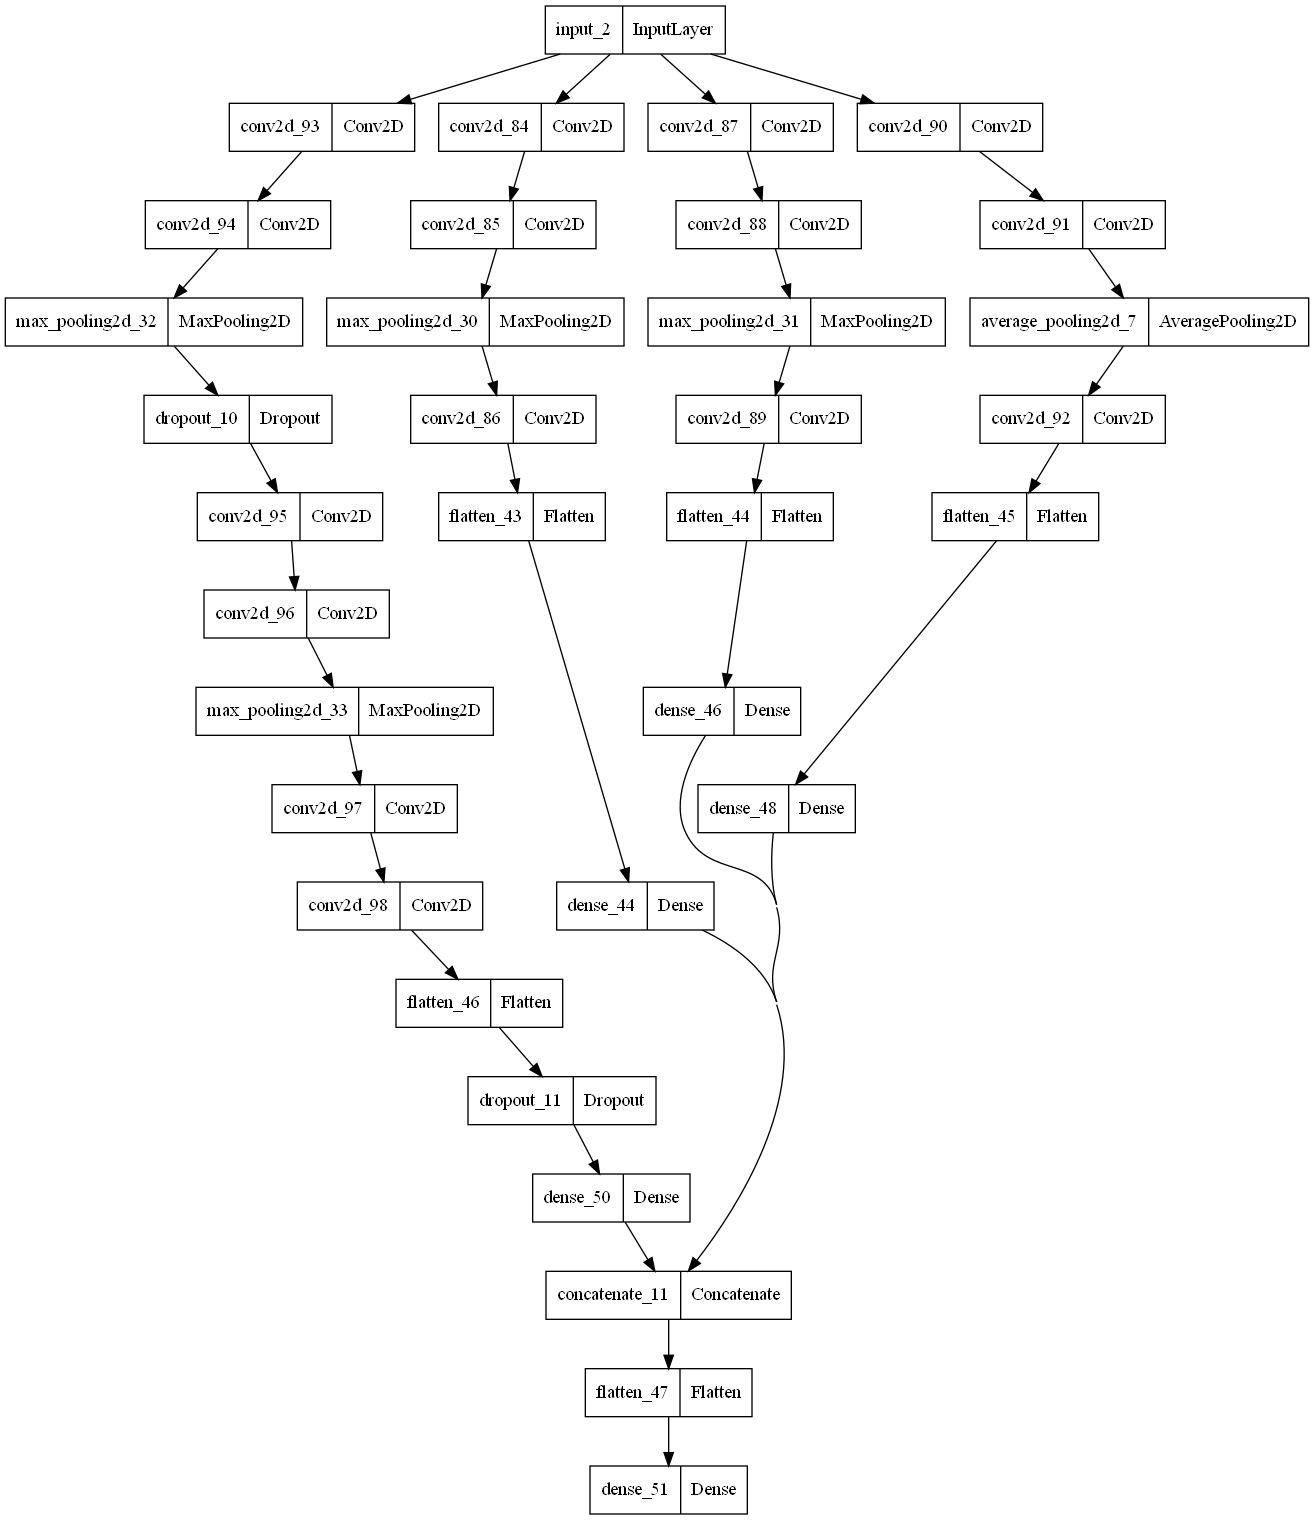

In [123]:
plot_model(model_stek,'model_stek.png')

In [125]:
print(f'Точность accuracy: {model_stek.evaluate(x_test,y_test, verbose=0)[1]}')

Точность accuracy: 0.6563000082969666


#### Улучшения также не наблюдается.

### Итог
- Добавление доп нитей повышает качество.
- Добавление конв. слоев повышает качество.
- Добавление ядер увеличивает качество.
- добавление полносвязных слоев не повышает.
- увеличение ширины полносвязного не добавляет качества.